In [1]:
import numpy as np

import math as m 
from scipy.special import gamma, loggamma, digamma
from scipy.optimize import brentq

import torch
from torch.autograd import Variable

import matplotlib.pyplot as plt

import pymanopt
from pymanopt.manifolds import Stiefel
from pymanopt.solvers import TrustRegions, ConjugateGradient, SteepestDescent

from tqdm import tqdm

## PDF

In [2]:
def pdfMST(y, μ, A, D, ν):
    """
    pdf of MST
    y: M
    μ: batch x M
    D: batch x MxM
    A: batch x M
    ν: batch x M
    """
    th2 = A * ν
    th1 = (1 + (D.transpose(1, 2)@(y - μ).unsqueeze(-1)).squeeze(-1) ** 2 / th2).log()
    exponent = - (ν + 1) / 2
    
    main = exponent * th1
    
    gam1 = ((ν + 1) / 2).lgamma()
    gam2 = (ν / 2).lgamma()
    th2 = gam1 - (gam2 + 0.5 * (m.pi * th2).log())
    
    main += th2
    
    return main.sum(1).exp()

def pdfMMST(π, MST=None, μ=None, A=None, D=None, ν=None):
    """
    log pdf of mixture of MST
    y: M
    π: K
    μ: K x M
    D: K x MxM
    A: K x M
    ν: K x M
    """
    if MST is not None:
        return (π * MST).sum()
    else:
        return (π * pdfMST(y, μ, A, D, ν)).sum()

## Sampling

In [3]:
def sampleMST(N, μ, A, D, ν):
    """
    sampling from MST
    μ: batch x M
    D: batch x MxM
    A: batch x M
    ν: batch x M
    """
    
    batch, M = μ.size()
    X = torch.distributions.MultivariateNormal(torch.zeros(M), scale_tril=torch.diag(torch.ones(M))).sample((batch, N,))
    
    W = torch.distributions.Gamma(ν / 2, ν / 2).sample((N,))
    W = W.transpose(0, 1)
    
    X /= W.sqrt()
    
    matA = torch.diag_embed(A.sqrt(), offset=0, dim1=-2, dim2=-1)
    coef = D@matA
    
    gen = μ.unsqueeze(1) + (coef@X.transpose(2, 1)).transpose(1, 2)
    
    return gen 

def sampleMMST(N, π, μ, A, D, ν):
    """
    sampling from MMST
    N: int
    π: K
    μ: K x M
    D: K x MxM
    A: K x M
    ν: K x M    
    """
    classes = torch.multinomial(π, N, replacement=True)
    
    gen = sampleMST(N, μ, A, D, ν)
    gen_mix = torch.tensor([], dtype=torch.float)
    
    for k in range(len(π)):
        gen_mix = torch.cat((gen_mix, gen[k, classes == k, :]))
    
    idx = torch.randperm(N)
    return gen_mix[idx]



In [4]:
π = torch.tensor([.3, .5, .2], dtype=torch.float)
μ = torch.tensor([[0, -6], [0, 0], [0, 6]], dtype=torch.float)
angle = m.pi / 6
matRot = [[m.cos(angle), -m.sin(angle)], [m.sin(angle), m.cos(angle)]]
D = torch.tensor([matRot, matRot, matRot], dtype=torch.float)
A = torch.ones(3,2, dtype=torch.float)
ν = torch.tensor([[1, 30], [1, 30], [1, 30]], dtype=torch.float)

gen_mix = sampleMMST(4000, π, μ, A, D, ν)

print(gen_mix.shape)

torch.Size([4000, 2])


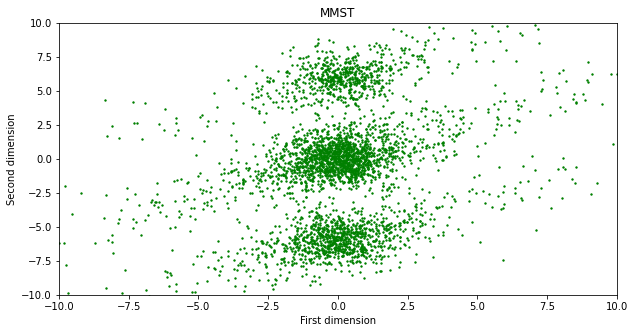

In [5]:
plt.figure(figsize=(10, 5))

plt.scatter(gen_mix[:, 0], gen_mix[:, 1], s=1.9, c='green')

plt.xlim(-10, 10)
plt.xlabel('First dimension')

plt.ylim(-10, 10)
plt.ylabel('Second dimension')

plt.title('MMST')
plt.show()

In [86]:
#3D mixtures
π = torch.tensor([.3, .5, .2], dtype=torch.float)
μ = torch.tensor([[0, -6, 0], [0, 0, 0], [0, 6, 0]], dtype=torch.float)
angle = m.pi / 6
matRot = [[1, 0, 0], [0, m.cos(angle), -m.sin(angle)], [0, m.sin(angle), m.cos(angle)]]
D = torch.tensor([matRot, matRot, matRot], dtype=torch.float)
A = torch.ones(3, 3, dtype=torch.float)
ν = torch.tensor([[1, 10, 30], [1, 10, 30], [1, 10, 30]], dtype=torch.float)
gen_mix = sampleMMST(4000, π, μ, A, D, ν)

print(gen_mix.shape)

torch.Size([4000, 3])


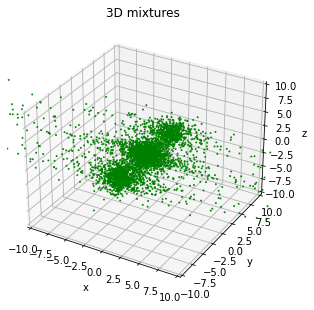

In [87]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')

ax.scatter(gen_mix[:, 0], gen_mix[:, 1], gen_mix[:, 2], s=1, c='green')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)

ax.set_title("3D mixtures")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.show()

## Updates EM

### Update Stats

In [8]:
def alpha_beta(y, μ, A, D, ν):
    """
    y: M
    μ: batch x M
    D: batch x MxM
    A: batch x M
    ν: batch x M
    """
    tmp = ν / 2
    
    α = tmp + 0.5
    β = tmp + (D.transpose(1, 2)@(y - μ).unsqueeze(-1)).squeeze(-1) ** 2 / (2 * A)
    
    return α, β

def U(α, β):
    "U: batch x M"
    return α / β

def Utilde(α, β):
    "Utilde: batch x M"
    return torch.digamma(α) - torch.log(β)

In [9]:
def updateStat(y, μ, A, D, ν, r, γ, stat):   
    """
    Update stats only
    y: M
    μ: K x M
    D: K x MxM
    A: K x M
    ν: K x M
    r: K
    γ: float
    stat: dict of stat
    """
    stat['s0'] = γ * r  + (1 - γ) * stat['s0']
    
    α, β = alpha_beta(y, μ, A, D, ν)
    u, utilde = U(α, β), Utilde(α, β)
    r = r.unsqueeze(-1)
    ru, rutilde = r * u, r * utilde
    
    y_unsqueeze = y.unsqueeze(-1)
    ymat = y_unsqueeze@y_unsqueeze.T
    
    stat['s1'] = γ * torch.einsum('ij,k->ijk', ru , y) + (1 - γ) * stat['s1']
    stat['S2'] = γ * torch.einsum('ij,kl->ijkl', ru , ymat) + (1 - γ) * stat['S2']
    stat['s3'] = γ * ru + (1 - γ) * stat['s3']
    stat['s4'] = γ * rutilde  + (1 - γ) * stat['s4']
    
    return stat

### Update params

In [10]:
# Update ν
def fun_ν(νkm, s3km, s4km):
    return s4km - s3km - digamma(νkm / 2) + np.log(νkm / 2) + 1

def update_ν(stat):
    K, M = stat['s3'].shape
    new_ν = np.zeros((K, M))
    for k in range(K):
        for m in range(M):
            s3km, s4km = (stat['s3'][k, m] / stat['s0'][k]).numpy() , (stat['s4'][k, m] / stat['s0'][k]).numpy()
            fun = lambda x : fun_ν(x, s3km, s4km)
            new_ν[k, m] = brentq(fun, .001, 100)
    return torch.tensor(new_ν, dtype=torch.float)

In [11]:
# Update μ
def update_μ(stat, D):
    S3_inv = torch.diag_embed(1 / (stat['s3'] / stat['s0'].unsqueeze(-1)), offset=0, dim1=-2, dim2=-1)
    v = torch.diagonal(torch.matmul(D.transpose(1, 2), (stat['s1'] / stat['s0'][:, None, None]).transpose(1, 2)), offset=0, dim1=-2, dim2=-1).unsqueeze(-1)
    return torch.matmul(D, torch.matmul(S3_inv, v)).squeeze(-1), v.squeeze(-1)


In [12]:
# Update A
# version sans boucle ? efficace ? 
def update_A(stat, D, v):
    S2 = stat['S2'] / stat['s0'][:, None, None, None]
    s3 = stat['s3'] / stat['s0'].unsqueeze(-1)

    tmp = torch.matmul(D[:, None, ...].transpose(-2, -1), S2)
    tmp = torch.matmul(tmp, D[:, None, ...])
    tmp = torch.diagonal(tmp, offset=0, dim1=-2, dim2=-1)
    return torch.diagonal(tmp, offset=0, dim1=-2, dim2=-1) - v ** 2 / s3

def update_A_loop(stat, D, v):
    S2 = stat['S2'] / stat['s0'][:, None, None, None]
    s3 = stat['s3'] / stat['s0'].unsqueeze(-1)
    s1 = stat['s1'] / stat['s0'][:, None, None]
    
    K, M, _ = D.shape
    A_new = torch.zeros(K, M)
    for k in range(K):
        for m in range(M):
            A_new[k, m] = D[k, :, m]@S2[k, m]@D[k, :, m] - (D[k, :, m]@s1[k, m])**2 / s3[k, m]
    return A_new

In [13]:
# Update π
def update_π(stat):
    return stat['s0'] # / stat['s0'].sum() à rajouter si on initialise pas avec des probas

In [14]:
# Update D

# objective
def fun(D, s1, S2, s3):
    K, M = s3.shape

    tmp = s1 / s3.unsqueeze(-1)
    matOpt = (S2 - torch.matmul(tmp.unsqueeze(-1), s1[:, :, None, :]))
    
    tmp = torch.matmul(D[:, None, ...].transpose(-2, -1), matOpt)
    tmp = torch.matmul(tmp, D[:, None, ...])
    tmp = torch.diagonal(tmp, offset=0, dim1=-2, dim2=-1)
    value = torch.diagonal(tmp, offset=0, dim1=-2, dim2=-1)
    return value.log().sum(-1)

#### Natural Gradient ####
def grad(D, s1, S2, s3):
    K, M = s3.shape

    tmp = s1 / s3.unsqueeze(-1)
    matOpt = (S2 - torch.matmul(tmp.unsqueeze(-1), s1[:, :, None, :]))

    # denom
    tmp = torch.matmul(D[:, None, ...].transpose(-2, -1), matOpt)
    tmp = torch.matmul(tmp, D[:, None, ...])
    tmp = torch.diagonal(tmp, offset=0, dim1=-2, dim2=-1)
    denom = torch.diagonal(tmp, offset=0, dim1=-2, dim2=-1)

    matOpt *= 2
    grad = torch.zeros(K, M, M)
    for k in range(K):
        for m in range(M):
            grad[k, m] = matOpt[k, m]@D[k,:,m] / denom[k, m]

    natural_grad = grad - torch.matmul(D, torch.matmul(grad.transpose(1, 2), D))
    
    return natural_grad


def natSGD(D, s1, S2, s3):
    D_new = torch.clone(D)
    eta = 1e-2
    for _ in range(300):
        nat_grad = grad(D_new, s1, S2, s3)
        D_new -= eta * nat_grad
    return D_new

#### package ####
def update_D(D, stat, solver=TrustRegions()):
    s1 = stat['s1'] / stat['s0'][:, None, None]
    s3 = stat['s3'] / stat['s0'].unsqueeze(-1)
    S2 = stat['S2'] / stat['s0'][:, None, None, None]
    
    manifold = Stiefel(D.shape[1], D.shape[2])
    
    def find_cost(k, s1, S2, s3):
        @pymanopt.function.pytorch(manifold)
        def cost(D):
            sum_all = 0
            M = len(D[0])
            for m in range(M):
                tmp = s1[k, m] / s3[k, m]
                matQuad = (S2[k, m] - tmp.unsqueeze(-1)@s1[k, m].unsqueeze(-1).T)
                quadForm = D[:, m].T @ matQuad.type(torch.float64) @ D[:, m]
                sum_all += quadForm.log()
            return sum_all
        return cost
    
    D_new = np.zeros(D.shape)
    for k in range(len(D)):
        cost = find_cost(k, s1, S2, s3)
        problem = pymanopt.Problem(manifold, cost, verbosity=0)
        D_new[k] = solver.solve(problem)
    D_new = torch.tensor(D_new, dtype=torch.float)
    return D_new

In [ ]:
a = time.time()
D_new_manOPT_conj = update_D(D, stat, SteepestDescent())
print(time.time() - a)
a = time.time()
D_new_manOPT_tr = update_D(D, stat)
print(time.time() - a)

print("départ: ", fun(D, s1, S2, s3))

print("methode 1: ", fun(D_new_manOPT_conj, s1, S2, s3))

print("methode 2: ", fun(D_new_manOPT_tr, s1, S2, s3))

In [15]:
def updateParams(y, π, μ, A, D, ν, stat):
    π_new = update_π(stat)
    D_new = update_D(D, stat)
    μ_new, v = update_μ(stat, D_new)
    A_new = update_A(stat, D_new, v)
    ν_new = update_ν(stat)
    return π_new, μ_new, A_new, D_new, ν_new

## EM

In [48]:
# K, M = 3, 2 real data
π = torch.tensor([.3, .5, .2], dtype=torch.float)
μ = torch.tensor([[0, -6], [0, 0], [0, 6]], dtype=torch.float)
angle = np.pi / 6
matRot = [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
D = torch.tensor([matRot, matRot, matRot], dtype=torch.float)
A = torch.ones(3,2, dtype=torch.float)
ν = torch.tensor([[1, 30], [1, 30], [1, 30]], dtype=torch.float)

gen_mix = sampleMMST(4000, π, μ, A, D, ν)
gen_mix = torch.tensor(np.array(sorted(gen_mix.numpy(), key=lambda e: abs(e.max()) < 10 and abs(e.min()) < 10)[::-1]), dtype=torch.float)


In [78]:
π = torch.tensor([.3, .5, .2], dtype=torch.float)
μ = torch.tensor([[0, -6, 0], [0, 0, 0], [0, 6, 0]], dtype=torch.float)
angle = m.pi / 6
matRot = [[1, 0, 0], [0, m.cos(angle), -m.sin(angle)], [0, m.sin(angle), m.cos(angle)]]
D = torch.tensor([matRot, matRot, matRot], dtype=torch.float)
A = torch.ones(3, 3, dtype=torch.float)
ν = torch.tensor([[1, 10, 30], [1, 10, 30], [1, 10, 30]], dtype=torch.float)
gen_mix = sampleMMST(4000, π, μ, A, D, ν)

gen_mix = sampleMMST(4000, π, μ, A, D, ν)
gen_mix = torch.tensor(np.array(sorted(gen_mix.numpy(), key=lambda e: abs(e.max()) < 10 and abs(e.min()) < 10)[::-1]), dtype=torch.float)


In [79]:
# real estimation 
from sklearn.cluster import KMeans
model = KMeans(3, max_iter=3000, tol=1e-5)
gen_mix_init = gen_mix[:500]
model.fit(gen_mix_init.numpy())
torch.tensor([(model.labels_ == k).sum() / len(model.labels_) for k in range(3)], dtype=torch.float)

π_pred = torch.tensor([(model.labels_ == k).sum() / len(model.labels_) for k in range(3)], dtype=torch.float)
μ_pred = torch.tensor(np.array([gen_mix_init[model.labels_ == k].numpy().mean(0) for k in range(3)]), dtype=torch.float)
D_pred = torch.tensor(np.array([np.eye(3), np.eye(3), np.eye(3)]), dtype=torch.float)
A_pred = torch.tensor(np.ones(A.shape), dtype=torch.float)
ν_pred = torch.tensor(30 * np.ones(ν.shape), dtype=torch.float)

In [80]:
#burnin
stat = {'s0': torch.zeros(len(π)), 's1': torch.zeros(D.shape), 'S2': torch.zeros((*D.shape, μ.shape[-1])), 
         's3': torch.zeros(A.shape), 's4': torch.zeros(A.shape)}
γ = (1-10e-10)*torch.tensor([k for k in range(1, len(gen_mix) + 1)]) ** (-6/10)
for i in range(500):
    y = gen_mix[i]
    mst = pdfMST(y, μ_pred, A_pred, D_pred, ν_pred)
    r = π_pred * mst / pdfMMST(π_pred, mst)
    stat = updateStat(y, μ_pred, A_pred, D_pred, ν_pred, r, γ[i], stat)

In [81]:
stat 

{'s0': tensor([0.3183, 0.5171, 0.1646]),
 's1': tensor([[[-0.0836, -1.7262,  0.0828],
          [-0.1216, -1.8756,  0.0821],
          [-0.1217, -1.8613,  0.0819]],
 
         [[ 0.0347,  0.0299, -0.1232],
          [ 0.0767,  0.0312, -0.1234],
          [ 0.0729,  0.0313, -0.1133]],
 
         [[-0.0780,  0.8914,  0.0452],
          [-0.1105,  0.9608,  0.0475],
          [-0.1168,  0.9658,  0.0456]]]),
 'S2': tensor([[[[ 0.9128,  0.4801, -0.1579],
           [ 0.4801, 10.1720, -0.4587],
           [-0.1579, -0.4587,  0.2377]],
 
          [[ 1.3135,  0.6936, -0.1902],
           [ 0.6936, 11.0785, -0.4550],
           [-0.1902, -0.4550,  0.2551]],
 
          [[ 1.3053,  0.6936, -0.1836],
           [ 0.6936, 10.9878, -0.4521],
           [-0.1836, -0.4521,  0.2465]]],
 
 
         [[[ 0.8507,  0.0446, -0.0121],
           [ 0.0446,  0.5172, -0.0385],
           [-0.0121, -0.0385,  0.5130]],
 
          [[ 1.3386,  0.0228, -0.0389],
           [ 0.0228,  0.5015, -0.0387],
           [

In [82]:
for i in tqdm(range(500, 1200)):
    y = gen_mix[i]
    mst = pdfMST(y, μ_pred, A_pred, D_pred, ν_pred)
    r = π_pred * mst / pdfMMST(π_pred, mst)
    π_pred, μ_pred, A_pred, D_pred, ν_pred = updateParams(y, π_pred, μ_pred, A_pred, D_pred, ν_pred, stat)
    stat = updateStat(y, μ_pred, A_pred, D_pred, ν_pred, r, γ[i], stat)

100%|██████████████████████████████████████████████████████████████████████████████████| 700/700 [01:07<00:00, 10.38it/s]


## Clustering

In [83]:
cluster_lab = torch.zeros(len(gen_mix))

for i, y in enumerate(gen_mix):
    mst = pdfMST(y, μ_pred, A_pred, D_pred, ν_pred)
    r = π_pred * mst / pdfMMST(π_pred, mst)
    cluster_lab[i] = torch.argmax(r)

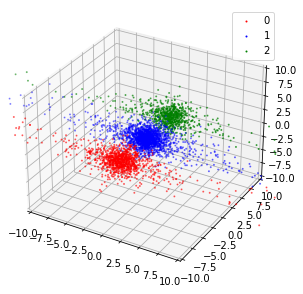

In [85]:
cdict = {0: 'red', 1: 'blue', 2: 'green'}

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')

for g in torch.unique(cluster_lab):
    ix = torch.where(cluster_lab == g)
    ax.scatter(gen_mix[:,0][ix], gen_mix[:,1][ix], gen_mix[:,2][ix], c = cdict[int(g)], label = int(g), s = 1)
ax.legend()
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
plt.show()